In [21]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
data_path = '/tf/data/ADReSS-IS2020'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [4]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [5]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):    
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0]
    label = meta.MMSE[meta.ID == name + ' ']
    return label.tolist()

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
def get_data_old(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    
    zero_padding = tf.zeros([10000000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

def window(x, size, stride):
    length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range(int((length-size)/stride)+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=44100*15, stride=44100)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=255, frame_step=128)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label

In [9]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(1000)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .shuffle(1000)
    return output_ds

In [10]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [12]:
for spectrogram, y in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)
    print(y)

(5166, 129, 1)
tf.Tensor(23, shape=(), dtype=int64)


In [13]:
batch_size = 8
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [15]:
print('Input shape:', input_shape)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.summary()

Input shape: (5166, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)               

In [16]:
model.compile(
    optimizer="adam",
    loss='mse',
    metrics='mse'
)

In [17]:
EPOCHS = 100
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS
)

Epoch 1/100
10/10 [==============================] - 16s 2s/step - loss: 527.9071 - mse: 527.9071 - val_loss: 254.8847 - val_mse: 254.8847
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 245.9295 - mse: 245.9295 - val_loss: 102.8256 - val_mse: 102.8256
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 121.8962 - mse: 121.8962 - val_loss: 98.0521 - val_mse: 98.0521
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 173.8848 - mse: 173.8848 - val_loss: 67.4437 - val_mse: 67.4437
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 81.9413 - mse: 81.9413 - val_loss: 58.0139 - val_mse: 58.0139
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 61.9625 - mse: 61.9625 - val_loss: 56.7270 - val_mse: 56.7270
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 72.5192 - mse: 72.5192 - val_loss: 54.8039 - val_mse: 54.8039
Epoch 8/100
10/10 [==================

Epoch 61/100
10/10 [==============================] - 0s 15ms/step - loss: 32.5212 - mse: 32.5212 - val_loss: 72.7187 - val_mse: 72.7187
Epoch 62/100
10/10 [==============================] - 0s 16ms/step - loss: 29.0554 - mse: 29.0554 - val_loss: 77.7584 - val_mse: 77.7584
Epoch 63/100
10/10 [==============================] - 0s 17ms/step - loss: 43.9145 - mse: 43.9145 - val_loss: 82.4421 - val_mse: 82.4421
Epoch 64/100
10/10 [==============================] - 0s 16ms/step - loss: 33.7144 - mse: 33.7144 - val_loss: 96.4575 - val_mse: 96.4575
Epoch 65/100
10/10 [==============================] - 0s 16ms/step - loss: 42.3487 - mse: 42.3487 - val_loss: 88.6795 - val_mse: 88.6795
Epoch 66/100
10/10 [==============================] - 0s 15ms/step - loss: 37.0809 - mse: 37.0809 - val_loss: 94.9402 - val_mse: 94.9402
Epoch 67/100
10/10 [==============================] - 0s 14ms/step - loss: 37.0910 - mse: 37.0910 - val_loss: 84.6841 - val_mse: 84.6841
Epoch 68/100
10/10 [=====================

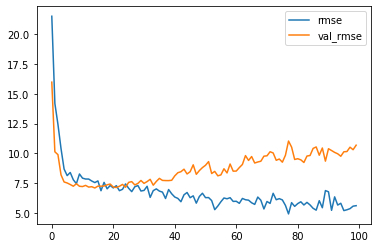

In [22]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mse']), np.sqrt(metrics['val_mse']))
plt.legend(['rmse', 'val_rmse'])
plt.show()